In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
# 合成数据
def synthetic_data(w, b, num_examples):
    "生成y=Xw+b+噪音"
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print("features: ", features[0], "\nlabels:", labels[0])

features:  tensor([ 1.2870, -0.6733]) 
labels: tensor([9.0643])


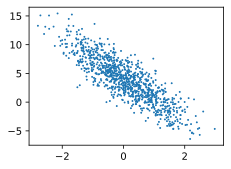

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

In [19]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 随机读取样本
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.8424,  0.6057],
        [ 0.7970, -1.1319],
        [-0.3163, -1.0018],
        [-0.4375, -0.5281],
        [ 0.1996,  1.1413],
        [-1.0639,  1.0566],
        [-0.6702, -0.2536],
        [-0.3656,  0.2379],
        [-0.5037,  0.4041],
        [-0.0133,  0.1011]]) 
 tensor([[ 0.4605],
        [ 9.6347],
        [ 6.9964],
        [ 5.1215],
        [ 0.7213],
        [-1.5213],
        [ 3.7231],
        [ 2.6653],
        [ 1.8073],
        [ 3.8253]])


In [40]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [10]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [21]:
def squared_loss(y_hat, y):
    """均方损失"""
    # print(y_hat.shape, y.shape)
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [37]:
# 定义优化函数
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad /batch_size
            param.grad.zero_()

In [41]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # 因为l的形状是(batch_size, 1)，而不是一个标量，累加并以此计算参数的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")

epoch 1, loss 0.058928
epoch 2, loss 0.000295
epoch 3, loss 0.000052


In [28]:
print(f"w的估计误差：{true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差：{true_b -b}")

w的估计误差：tensor([9.5248e-05, 5.7554e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0005], grad_fn=<RsubBackward1>)
